In [ ]:
# https://radimrehurek.com/gensim/auto_examples/tutorials/run_doc2vec_lee.html#sphx-glr-auto-examples-tutorials-run-doc2vec-lee-py
# https://towardsdatascience.com/multi-class-text-classification-with-doc2vec-logistic-regression-9da9947b43f4

In [18]:
# import pandas as pd
# import numpy as np
# from tqdm import tqdm
# tqdm.pandas(desc="progress-bar")
# from gensim.models import Doc2Vec
# from sklearn import utils
# import gensim
# from sklearn.linear_model import LogisticRegression
# import re
# import seaborn as sns
# import matplotlib.pyplot as plt
# import os
# from bs4 import BeautifulSoup

# import multiprocessing
# cores = multiprocessing.cpu_count()
# import logging
# logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
# from gensim.test.utils import get_tmpfile
# from sklearn.metrics import accuracy_score, f1_score
# import collections

import pandas as pd
import numpy as np
from gensim.models import Doc2Vec
from gensim.models.doc2vec import TaggedDocument
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.svm import SVC
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import RocCurveDisplay
from sklearn import metrics
import matplotlib.pyplot as plt
import pickle

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Nick\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [51]:
completed_non_ea_bibs = []
completed_non_ea_text = []
with open('.//data//non_ea_papers_text.txt', 'r', encoding="utf-8") as f:
    for line in f:
        bib = line.split(",")[0].strip()
        text = line.split(",")[1].strip()
        completed_non_ea_bibs.append(bib)
        completed_non_ea_text.append(text)
n_neg = len(completed_non_ea_bibs)

completed_ea_bibs = []
completed_ea_text = []
with open('.//data//ea_papers_text.txt', 'r', encoding="utf-8") as f:
    for line in f:
        bib = line.split(",")[0].strip()
        text = line.split(",")[1].strip()
        completed_ea_bibs.append(bib)
        completed_ea_text.append(text)
n_pos = len(completed_ea_bibs)

pos_training_corpus = pd.DataFrame({"text":completed_ea_text, "label":np.repeat(1, len(completed_ea_bibs))})
neg_training_corpus = pd.DataFrame({"text":completed_non_ea_text, "label":np.repeat(0, len(completed_non_ea_bibs))})

training_corpus = pd.concat([pos_training_corpus, neg_training_corpus])
training_corpus = training_corpus.sample(frac=1, random_state=42).reset_index(drop=True)
training_corpus["index"] = training_corpus.index

In [15]:
print(n_pos, n_neg)

3538 4025


In [57]:
training_corpus

,text,label,index
0,arxivastroph0403324v4 17 jul 2022dark matter ...,0,0
1,mon not r astron soc 000 19 0000 printed 20 au...,1,1
2,mon not r astron soc 427 3435–3467 2012 doi101...,0,2
3,astronomy astrophysics manuscript no hd20v2 ce...,1,3
4,the microphysics of collisionless shock wavesa...,0,4
...,...,...,...
7558,mon not r astron soc 360 869–891 2005 doi10111...,0,7558
7559,arxivastroph0508228v1 10 aug 2005adarkjetdomi...,0,7559
7560,1accepted for publication in nature20 october ...,0,7560
7561,arxiv11045230v3 astrophep 7 jul 2011accepted...,1,7561


In [3]:
stopWords = set(stopwords.words('english'))

def tokenize_text(text):
    tokens = []
    for sentence in nltk.sent_tokenize(text):
        for word in nltk.word_tokenize(sentence):
            if len(word) < 2 or word in stopWords:
                continue
            tokens.append(word.lower())
    return tokens

# punctuation was removed and text was set to lower case earlier (Convert PDFs to Text.ipynb)

# training_corpus_tagged = training_corpus.apply(lambda r: TaggedDocument(words=tokenize_text(r['text']), tags=[r["label"]]), axis=1).tolist()

In [2]:
fname = ".//models//doc2vec//model_dbow_vs_600_n_5_s_0.bin"

doc2vec_model = Doc2Vec.load(fname)

In [5]:
# X, y = zip(*[(doc2vec_model.infer_vector(doc.words), doc.tags[0]) for doc in training_corpus_tagged])
# df = pd.DataFrame(X)
# df["label"] = y
# df.shape

(7563, 601)

In [3]:
fname = ".//data//model_dbow_vs_600_n_5_s_0_inferred_training_data.csv"
# df.to_csv(fname)
df = pd.read_csv(fname).drop("Unnamed: 0", axis=1)
df.head()

,0,1,2,3,4,5,6,7,8,9,...,591,592,593,594,595,596,597,598,599,label
0,-0.024851,-0.381951,-0.651674,0.553038,1.299930,1.031808,0.333705,-0.101893,0.053647,0.222175,...,0.421792,0.843307,0.379752,0.410750,-0.602648,0.904846,-0.157149,-0.013713,0.633879,0
1,0.388153,0.000402,0.285238,-1.093168,-0.517576,-0.442416,0.572925,-0.000812,-0.088989,0.351440,...,-0.067700,0.308366,-0.036528,0.238906,-0.149262,0.399019,0.196109,-0.883065,-0.541812,1
2,0.570890,-0.482221,-0.214128,-0.549572,-0.095529,0.389266,-0.176438,-0.252203,0.049001,-0.112858,...,0.731259,0.627417,-0.015409,0.238097,0.032458,0.268519,-0.307194,0.311125,-0.459251,0
3,-0.098389,-0.022716,-0.856276,-0.721896,-0.125313,0.093145,0.662419,-0.438362,0.227312,0.410582,...,0.232290,-0.118163,0.440777,-0.599077,0.119088,-0.006456,-0.144061,-0.186257,0.228160,1
4,-0.207901,-0.841178,0.095708,0.132864,0.298601,0.492365,-0.053234,0.299751,-0.317690,-0.691285,...,0.262907,0.732972,0.405798,0.046836,0.045763,-0.604552,0.789747,0.100230,0.029443,0


In [4]:
X = df.loc[:, df.columns != "label"]
y = df["label"]

In [5]:
X_train_valid, X_test, y_train_valid, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

In [ ]:
# https://machinelearningmastery.com/cost-sensitive-svm-for-imbalanced-classification/
# https://www.kdnuggets.com/2017/06/7-techniques-handle-imbalanced-data.html

In [ ]:
# https://machinelearningmastery.com/tour-of-evaluation-metrics-for-imbalanced-classification/
# https://towardsdatascience.com/multi-class-metrics-made-simple-part-ii-the-f1-score-ebe8b2c2ca1

## SVM

In [8]:
cv = RepeatedStratifiedKFold(n_splits=10, random_state=42)

svm_model = SVC()

auc_scores = cross_val_score(svm_model, X_train_valid, y_train_valid, scoring='roc_auc', cv=cv, n_jobs=-1)
print('Mean ROC AUC: %.3f' % np.mean(auc_scores))

Mean ROC AUC: 0.997


In [13]:
param_grid = { 
    "C": np.logspace(-1, 1, 5),
    "kernel": ['rbf', 'poly'],
    "gamma": list(np.logspace(-1, 1, 5))+['scale', 'auto'],
    "class_weight": ["balanced", None]
    }

svm_model = SVC()
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=2, random_state=42)

grid_search = GridSearchCV(estimator=svm_model, param_grid=param_grid, scoring='roc_auc', n_jobs=-1, cv=cv, verbose=2, error_score='raise')
grid_result = grid_search.fit(X_train_valid, y_train_valid)

print(grid_result.best_score_)
print(grid_result.best_params_)

Fitting 10 folds for each of 140 candidates, totalling 1400 fits
0.9970612309370249
{'C': 0.31622776601683794, 'class_weight': 'balanced', 'gamma': 'auto', 'kernel': 'rbf'}


In [27]:
best_C = 0.31622776601683794
best_class_weight = "balanced"
best_gamma = "auto"
best_kernel = "rbf"

final_svm_model = SVC(C=best_C, class_weight=best_class_weight, gamma=best_gamma, kernel=best_kernel, probability=True)
final_svm_model.fit(X_train_valid.values, y_train_valid.values)

preds = final_svm_model.predict(X_test.values)

fpr, tpr, thresholds = metrics.roc_curve(y_test.values, preds)
auc = metrics.auc(fpr, tpr)
print(auc)

acc = final_svm_model.score(X_test.values, y_test.values)
print(acc)

0.9777761463271384
0.9775429326287979


In [38]:
len(y_test[y_test==0])/len(y_test[y_test==1])

1.0853994490358128

In [28]:
fname = ".//models//doc2vec//svc.sav"
pickle.dump(final_svm_model, open(fname, 'wb'))

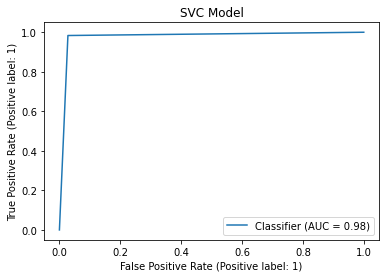

In [22]:
RocCurveDisplay.from_predictions(y_test, preds)
plt.title("SVC Model")
plt.show()

In [29]:
probs = final_svm_model.predict_proba(X_test.values)

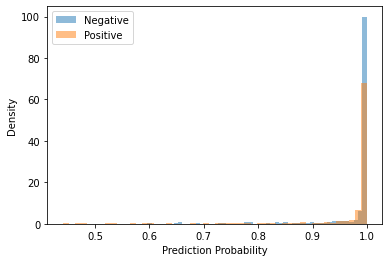

In [37]:
pos_probs = []
neg_probs = []
for i in range(len(preds)):
    pred = preds[i]
    prob = probs[i][pred]
    if pred == 0:
        neg_probs.append(prob)
    elif pred == 1:
        pos_probs.append(prob)
        
plt.hist(neg_probs, density=True, label="Negative", alpha=0.5, bins=50)
plt.hist(pos_probs, density=True, label="Positive", alpha=0.5, bins=50)
plt.xlabel("Prediction Probability")
plt.ylabel("Density")
plt.legend()
plt.show()

In [54]:
print(np.median(neg_probs))
print(np.median(pos_probs))

0.9984166657774174
0.9962809719586649


In [53]:
worst_pos_prob_ind = X_test.iloc[np.argmin(pos_probs),:].values[0]
row = X[X["0"] == worst_pos_prob_ind].index[0]
training_corpus.iloc[row,:]["text"]

'mon not r astron soc 335 l1–l5 2002a long hard look at mcg–63015 with xmmnewtona c fabian1⋆s vaughan1k nandra2k iwasawa1d r ballantyne1j c lee3a de rosa14a turner1and a j young51institute of astronomy university of cambridge madingley road cambridge cb3 0ha2laboratory for high energy astrophysics nasagoddard space flight centre greenbelt md 20771 usa3massachusetts institute of technology centre for space research 77 massachusetts ave ne80 cambridge ma 02139 usa4istituto di astroﬁsica spaziale c n r via fosso del cavaliere roma italy5astronomy department university of maryland college park md 20742 usaaccepted 2002 june 5 received 2002 may 30 in original form 2002 april 2abstractwe present the ﬁrst results from a 325ks observation of the seyfert 1 galaxy mcg–63015with xmmnewton andbepposax  the strong broad skewed iron line is clearly detected andis well characterized by a steep emissivity proﬁle within 6 rgie 6 gmc2 and a ﬂatter proﬁlebeyond the inner radius of the emission appears to

In [48]:
X[X["0"] == worst_pos_prob_ind].index[0]

1024